# BIKE SHARING DEMAND - MODELING

Este notebook contiene el entrenamiento y evaluación de modelos baseline para predicción de demanda de bicicletas compartidas.

## Objetivos:
1. Entrenar 3 modelos baseline (Linear Regression, Random Forest, XGBoost)
2. Registrar experimentos con MLflow
3. Evaluar con métricas objetivo (MAE < 50, RMSE < 80, R² > 0.7)
4. Analizar feature importance
5. Seleccionar mejor modelo para optimización

---

**Prerequisitos:**
- Datasets normalizados en `data/processed/`
- Scaler guardado en `models/scaler.pkl`
- Notebook anterior ejecutado con feature engineering completo

# 1. SETUP Y CONFIGURACIÓN

Importamos librerías, configuramos MLflow y definimos variables globales.

## 1.1 Imports


In [1]:
# Sistema y paths
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error
)

# MLflow
import mlflow
import mlflow.sklearn
import mlflow.xgboost

# Utilities
import joblib
from datetime import datetime
import json

# Configuración de plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Librerías importadas correctamente")
print(f"Fecha de ejecución: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


✓ Librerías importadas correctamente
Fecha de ejecución: 2025-10-11 17:52:51


## 1.2 Configuración de Paths y Constantes


In [2]:
# Directorios
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / 'data' / 'processed'
MODELS_DIR = PROJECT_ROOT / 'models'
MLFLOW_DIR = PROJECT_ROOT / 'mlruns'

# Crear directorios si no existen
MLFLOW_DIR.mkdir(exist_ok=True)

# Métricas objetivo (según análisis EDA)
TARGET_METRICS = {
    'MAE': 50,      # Mean Absolute Error < 50
    'RMSE': 80,     # Root Mean Squared Error < 80
    'R2': 0.7,      # R² > 0.7
    'MAPE': 25      # Mean Absolute Percentage Error < 25%
}

# Configuración MLflow
EXPERIMENT_NAME = "bike-sharing-demand-baseline"
mlflow.set_tracking_uri(f"file:///{MLFLOW_DIR}")

print("="*70)
print("CONFIGURACIÓN DEL PROYECTO")
print("="*70)
print(f"Project Root: {PROJECT_ROOT}")
print(f"Data Directory: {DATA_DIR}")
print(f"Models Directory: {MODELS_DIR}")
print(f"MLflow Tracking: {MLFLOW_DIR}")
print(f"\nMétricas Objetivo:")
for metric, target in TARGET_METRICS.items():
    print(f"  • {metric}: {'<' if metric != 'R2' else '>'} {target}")
print("="*70)


CONFIGURACIÓN DEL PROYECTO
Project Root: c:\Users\gairo\OneDrive\Documents\Tec_De_Monterrey\MLOps\Proyecto\mlops-team-61-project
Data Directory: c:\Users\gairo\OneDrive\Documents\Tec_De_Monterrey\MLOps\Proyecto\mlops-team-61-project\data\processed
Models Directory: c:\Users\gairo\OneDrive\Documents\Tec_De_Monterrey\MLOps\Proyecto\mlops-team-61-project\models
MLflow Tracking: c:\Users\gairo\OneDrive\Documents\Tec_De_Monterrey\MLOps\Proyecto\mlops-team-61-project\mlruns

Métricas Objetivo:
  • MAE: < 50
  • RMSE: < 80
  • R2: > 0.7
  • MAPE: < 25


# 2. CARGA DE DATOS

Cargamos los datasets normalizados generados en el notebook anterior.


## 2.1 Cargar Datasets Normalizados


In [3]:
# Cargar datasets
train_df = pd.read_csv(DATA_DIR / 'bike_sharing_features_train_normalized.csv')
val_df = pd.read_csv(DATA_DIR / 'bike_sharing_features_validation_normalized.csv')
test_df = pd.read_csv(DATA_DIR / 'bike_sharing_features_test_normalized.csv')

print("="*70)
print("DATASETS CARGADOS")
print("="*70)
print(f"Train: {train_df.shape}")
print(f"  Fecha inicio: {train_df['timestamp'].min()}")
print(f"  Fecha fin:    {train_df['timestamp'].max()}")
print(f"\nValidation: {val_df.shape}")
print(f"  Fecha inicio: {val_df['timestamp'].min()}")
print(f"  Fecha fin:    {val_df['timestamp'].max()}")
print(f"\nTest: {test_df.shape}")
print(f"  Fecha inicio: {test_df['timestamp'].min()}")
print(f"  Fecha fin:    {test_df['timestamp'].max()}")
print("="*70)

# Verificar integridad
assert train_df.shape[1] == val_df.shape[1] == test_df.shape[1], "Datasets tienen diferente número de columnas"
assert train_df.isnull().sum().sum() == 0, "Train tiene valores nulos"
assert val_df.isnull().sum().sum() == 0, "Validation tiene valores nulos"
assert test_df.isnull().sum().sum() == 0, "Test tiene valores nulos"

print("\n✓ Verificación de integridad completada")


DATASETS CARGADOS
Train: (5063, 73)
  Fecha inicio: 2011-01-11 01:00:00
  Fecha fin:    2011-10-31 23:00:00

Validation: (1032, 73)
  Fecha inicio: 2011-11-01 00:00:00
  Fecha fin:    2011-12-31 23:00:00

Test: (6258, 73)
  Fecha inicio: 2012-01-01 00:00:00
  Fecha fin:    2012-12-31 23:00:00

✓ Verificación de integridad completada


## 2.2 Preparar Features y Target


In [ ]:
# ============================================================================
# IMPORTANTE: ELIMINAR FEATURES CON DATA LEAKAGE
# ============================================================================
# Estas features contienen información del target y deben ser excluidas:
#
# 1. Componentes del target:
#    - casual, registered (cnt = casual + registered)
#    - casual_share, ratio_registered_casual
#    - casual_share_hr
#
# 2. Lags del TARGET (cnt):
#    - cnt_lag_1h, cnt_lag_24h, cnt_lag_168h
#    - cnt_roll_mean_3h, cnt_roll_mean_24h
#    - cnt_pct_change_1h, cnt_pct_change_24h
#    - cnt_acceleration, cnt_volatility_24h, cnt_diff_168h
#
# 3. Lags de componentes del target:
#    - registered_lag_*, registered_roll_mean_*, registered_vs_avg_24h
#    - casual_lag_*, casual_roll_mean_*, casual_vs_avg_24h
#
# Estas features causan data leakage porque contienen información futura
# del target que NO estaría disponible al momento de hacer predicciones.
# ============================================================================

# Metadata y targets
metadata_cols = ['timestamp', 'dteday']
target_cols = ['cnt', 'casual', 'registered']

# Features con DATA LEAKAGE que DEBEN ser excluidas
leakage_features = [
    # Componentes del target
    'casual_share', 'ratio_registered_casual', 'casual_share_hr',
    
    # Lags del target (cnt)
    'cnt_lag_1h', 'cnt_lag_24h', 'cnt_lag_168h',
    'cnt_roll_mean_3h', 'cnt_roll_mean_24h',
    'cnt_pct_change_1h', 'cnt_pct_change_24h',
    'cnt_acceleration', 'cnt_volatility_24h', 'cnt_diff_168h',
    
    # Lags de componentes del target
    'registered_lag_1h', 'registered_lag_24h', 'registered_lag_168h',
    'registered_roll_mean_3h', 'registered_roll_mean_24h',
    'registered_vs_avg_24h',
    'casual_lag_1h', 'casual_lag_24h', 'casual_lag_168h',
    'casual_roll_mean_3h', 'casual_roll_mean_24h',
    'casual_vs_avg_24h'
]

# Todas las columnas a excluir
exclude_cols = metadata_cols + target_cols + leakage_features

# Features válidas (solo las que NO contienen información del target)
all_cols = train_df.columns.tolist()
feature_cols = [col for col in all_cols if col not in exclude_cols]

print("="*70)
print("LIMPIEZA DE DATA LEAKAGE")
print("="*70)
print(f"Total columnas en dataset: {len(all_cols)}")
print(f"Columnas excluidas:")
print(f"  - Metadata: {len(metadata_cols)}")
print(f"  - Targets: {len(target_cols)}")
print(f"  - Data leakage: {len(leakage_features)}")
print(f"  Total excluidas: {len(exclude_cols)}")
print(f"\n✓ Features válidas (sin leakage): {len(feature_cols)}")

# Verificar que todas las features de leakage existen
missing_leakage = [f for f in leakage_features if f not in all_cols]
if missing_leakage:
    print(f"\n⚠️  Features de leakage no encontradas: {missing_leakage}")

# Separar X e y
X_train = train_df[feature_cols].values
y_train = train_df['cnt'].values

X_val = val_df[feature_cols].values
y_val = val_df['cnt'].values

X_test = test_df[feature_cols].values
y_test = test_df['cnt'].values

print("\n" + "="*70)
print("FEATURES VÁLIDAS SELECCIONADAS")
print("="*70)
print(f"Total features: {len(feature_cols)}\n")

# Agrupar features por categoría
time_features = [f for f in feature_cols if any(x in f for x in ['hr', 'mnth', 'weekday', 'yr', 'day_of', 'week_of', 'is_month', 'is_weekend', 'is_peak', 'is_commute', 'is_first'])]
weather_features = [f for f in feature_cols if any(x in f for x in ['temp', 'hum', 'wind', 'thermal', 'wind_chill', 'is_extreme'])]
categorical_features = [f for f in feature_cols if any(x in f for x in ['season_', 'weathersit_', 'holiday_', 'workingday_', 'weather_quadrant_'])]
interaction_features = [f for f in feature_cols if '_' in f and f not in time_features and f not in weather_features and f not in categorical_features]

print(f"Categorías de features:")
print(f"  • Temporales:     {len(time_features)}")
print(f"  • Climáticas:     {len(weather_features)}")
print(f"  • Categóricas:    {len(categorical_features)}")
print(f"  • Interacciones:  {len(interaction_features)}")

print(f"\nFeatures temporales (top 10):")
for i, feat in enumerate(time_features[:10], 1):
    print(f"  {i:2d}. {feat}")
if len(time_features) > 10:
    print(f"  ... y {len(time_features) - 10} más")

print(f"\nTarget: cnt (demanda total de bicicletas)")
print(f"\nShapes:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  X_val:   {X_val.shape}")
print(f"  y_val:   {y_val.shape}")
print(f"  X_test:  {X_test.shape}")
print(f"  y_test:  {y_test.shape}")

print(f"\nEstadísticas del target (cnt):")
print(f"  Train - Mean: {y_train.mean():.2f}, Std: {y_train.std():.2f}, Min: {y_train.min():.0f}, Max: {y_train.max():.0f}")
print(f"  Val   - Mean: {y_val.mean():.2f}, Std: {y_val.std():.2f}, Min: {y_val.min():.0f}, Max: {y_val.max():.0f}")
print(f"  Test  - Mean: {y_test.mean():.2f}, Std: {y_test.std():.2f}, Min: {y_test.min():.0f}, Max: {y_test.max():.0f}")
print("="*70)


FEATURES Y TARGET
Total features: 68

Features incluidos (primeros 10):
   1. yr
   2. mnth
   3. hr
   4. weekday
   5. temp
   6. hum
   7. windspeed
   8. hr_sin
   9. hr_cos
  10. mnth_sin
  ... y 58 más

Target: cnt (demanda total de bicicletas)

Shapes:
  X_train: (5063, 68)
  y_train: (5063,)
  X_val:   (1032, 68)
  y_val:   (1032,)
  X_test:  (6258, 68)
  y_test:  (6258,)

Estadísticas del target (cnt):
  Train - Mean: 161.15, Std: 289.66, Min: 1, Max: 9779
  Val   - Mean: 145.01, Std: 345.66, Min: 1, Max: 8892
  Test  - Mean: 249.61, Std: 351.44, Min: 1, Max: 8748


### ⚠️ **NOTA IMPORTANTE: DATA LEAKAGE ELIMINADO**

En la versión anterior del notebook, se incluyeron **40+ features con data leakage**, lo que causó resultados irreales:
- Ridge Regression: R² = 1.0000 (perfección imposible)
- MAE < 1 (demasiado bueno para ser verdad)

**Features problemáticas eliminadas:**
1. **Componentes directos del target**: `casual`, `registered`, `casual_share`, `ratio_registered_casual`
2. **Lags del target**: `cnt_lag_*`, `cnt_roll_mean_*`, `cnt_pct_change_*`, etc.
3. **Lags de componentes**: `casual_lag_*`, `registered_lag_*`, etc.

**¿Por qué es data leakage?**
- Estas features contienen información del **futuro** que NO estaría disponible al momento de predecir
- Por ejemplo, `cnt_lag_1h` = demanda de la hora anterior, pero ¿cómo predecirías la primera hora del día?
- `casual` + `registered` = `cnt` (el target es literalmente la suma de estas features)

**Métricas realistas esperadas ahora:**
- MAE: 40-60 (en lugar de < 1)
- RMSE: 60-100 (en lugar de < 1)  
- R²: 0.6-0.8 (en lugar de 1.0)
- MAPE: 20-30% (en lugar de < 1%)

Con **~42 features válidas**, el modelo será más realista pero seguirá siendo competitivo usando solo información disponible al momento de la predicción.


# 3. CONFIGURACIÓN DE MLFLOW

Configuramos el experimento de MLflow para tracking de modelos.


In [5]:
# Crear o obtener experimento
try:
    experiment_id = mlflow.create_experiment(
        EXPERIMENT_NAME,
        tags={
            "project": "mlops-team-61",
            "phase": "baseline-models",
            "dataset": "bike-sharing",
            "features": str(len(feature_cols))
        }
    )
    print(f"✓ Experimento creado: {EXPERIMENT_NAME}")
except:
    experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
    experiment_id = experiment.experiment_id
    print(f"✓ Experimento existente: {EXPERIMENT_NAME}")

mlflow.set_experiment(EXPERIMENT_NAME)

print(f"  Experiment ID: {experiment_id}")
print(f"  Tracking URI: {mlflow.get_tracking_uri()}")
print(f"\n📊 Para ver MLflow UI, ejecutar en terminal:")
print(f"   mlflow ui --backend-store-uri {mlflow.get_tracking_uri()}")
print(f"   Luego abrir: http://localhost:5000")


✓ Experimento creado: bike-sharing-demand-baseline
  Experiment ID: 679464065834608110
  Tracking URI: file:///c:\Users\gairo\OneDrive\Documents\Tec_De_Monterrey\MLOps\Proyecto\mlops-team-61-project\mlruns

📊 Para ver MLflow UI, ejecutar en terminal:
   mlflow ui --backend-store-uri file:///c:\Users\gairo\OneDrive\Documents\Tec_De_Monterrey\MLOps\Proyecto\mlops-team-61-project\mlruns
   Luego abrir: http://localhost:5000


# 4. FUNCIONES DE EVALUACIÓN

Definimos funciones reutilizables para evaluar modelos.


In [6]:
def evaluate_model(y_true, y_pred, dataset_name="Validation"):
    """
    Evalúa un modelo con múltiples métricas.
    
    Args:
        y_true: Valores reales
        y_pred: Valores predichos
        dataset_name: Nombre del dataset (Train/Validation/Test)
    
    Returns:
        dict: Diccionario con métricas calculadas
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    
    # Métricas adicionales
    residuals = y_true - y_pred
    
    metrics = {
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'mape': mape,
        'residuals_mean': residuals.mean(),
        'residuals_std': residuals.std()
    }
    
    return metrics


def print_metrics(metrics, dataset_name="Validation", targets=TARGET_METRICS):
    """
    Imprime métricas en formato legible con comparación vs targets.
    """
    print(f"\n{'='*70}")
    print(f"MÉTRICAS - {dataset_name.upper()}")
    print(f"{'='*70}")
    
    # MAE
    mae_status = "✓" if metrics['mae'] < targets['MAE'] else "✗"
    print(f"MAE:  {metrics['mae']:8.2f}  {mae_status}  (target: < {targets['MAE']})")
    
    # RMSE
    rmse_status = "✓" if metrics['rmse'] < targets['RMSE'] else "✗"
    print(f"RMSE: {metrics['rmse']:8.2f}  {rmse_status}  (target: < {targets['RMSE']})")
    
    # R²
    r2_status = "✓" if metrics['r2'] > targets['R2'] else "✗"
    print(f"R²:   {metrics['r2']:8.4f}  {r2_status}  (target: > {targets['R2']})")
    
    # MAPE
    mape_status = "✓" if metrics['mape'] < targets['MAPE'] else "✗"
    print(f"MAPE: {metrics['mape']:8.2f}% {mape_status}  (target: < {targets['MAPE']}%)")
    
    print(f"\nResiduos:")
    print(f"  Mean: {metrics['residuals_mean']:8.2f}  (debe estar ~0)")
    print(f"  Std:  {metrics['residuals_std']:8.2f}")
    print(f"{'='*70}")


def plot_predictions(y_true, y_pred, title="Predicciones vs Reales", sample_size=500):
    """
    Visualiza predicciones vs valores reales.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Scatter plot (muestra)
    idx = np.random.choice(len(y_true), min(sample_size, len(y_true)), replace=False)
    axes[0].scatter(y_true[idx], y_pred[idx], alpha=0.5, s=20)
    axes[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
                 'r--', lw=2, label='Perfect Prediction')
    axes[0].set_xlabel('Valores Reales')
    axes[0].set_ylabel('Predicciones')
    axes[0].set_title(f'{title} - Scatter')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Distribución de residuos
    residuals = y_true - y_pred
    axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
    axes[1].axvline(0, color='red', linestyle='--', lw=2, label='Zero Error')
    axes[1].axvline(residuals.mean(), color='green', linestyle='--', lw=2, 
                    label=f'Mean: {residuals.mean():.2f}')
    axes[1].set_xlabel('Residuos (Real - Predicción)')
    axes[1].set_ylabel('Frecuencia')
    axes[1].set_title('Distribución de Residuos')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("✓ Funciones de evaluación definidas")


✓ Funciones de evaluación definidas


# 5. MODELO 1: LINEAR REGRESSION (RIDGE)

Modelo baseline simple con regularización Ridge.


## 5.1 Entrenamiento


In [7]:
print("="*70)
print("MODELO 1: RIDGE REGRESSION")
print("="*70)

# Hiperparámetros
ridge_params = {
    'alpha': 1.0,
    'random_state': 42
}

# MLflow Run
with mlflow.start_run(run_name="ridge_baseline") as run:
    
    # Log parameters
    mlflow.log_params(ridge_params)
    mlflow.log_param("model_type", "Ridge Regression")
    mlflow.log_param("n_features", len(feature_cols))
    
    # Entrenar modelo
    print("\nEntrenando Ridge Regression...")
    ridge_model = Ridge(**ridge_params)
    ridge_model.fit(X_train, y_train)
    print("✓ Modelo entrenado")
    
    # Predicciones
    y_train_pred_ridge = ridge_model.predict(X_train)
    y_val_pred_ridge = ridge_model.predict(X_val)
    y_test_pred_ridge = ridge_model.predict(X_test)
    
    # Evaluar
    train_metrics_ridge = evaluate_model(y_train, y_train_pred_ridge, "Train")
    val_metrics_ridge = evaluate_model(y_val, y_val_pred_ridge, "Validation")
    test_metrics_ridge = evaluate_model(y_test, y_test_pred_ridge, "Test")
    
    # Log metrics
    for prefix, metrics in [('train', train_metrics_ridge), 
                             ('val', val_metrics_ridge),
                             ('test', test_metrics_ridge)]:
        for metric_name, value in metrics.items():
            mlflow.log_metric(f"{prefix}_{metric_name}", value)
    
    # Log model
    mlflow.sklearn.log_model(ridge_model, "model", 
                              registered_model_name="bike-demand-ridge")
    
    # Tags
    mlflow.set_tags({
        "model_family": "linear",
        "complexity": "low",
        "regularization": "L2"
    })
    
    print(f"\n✓ Run ID: {run.info.run_id}")

# Mostrar resultados
print_metrics(train_metrics_ridge, "Train")
print_metrics(val_metrics_ridge, "Validation")
print_metrics(test_metrics_ridge, "Test")


MODELO 1: RIDGE REGRESSION

Entrenando Ridge Regression...
✓ Modelo entrenado


2025/10/11 17:53:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/11 17:53:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



✓ Run ID: 966d020d9e2e4554872c4ee3e2aa3982

MÉTRICAS - TRAIN
MAE:      0.07  ✓  (target: < 50)
RMSE:     0.24  ✓  (target: < 80)
R²:     1.0000  ✓  (target: > 0.7)
MAPE:     0.22% ✓  (target: < 25%)

Residuos:
  Mean:    -0.00  (debe estar ~0)
  Std:      0.24

MÉTRICAS - VALIDATION
MAE:      0.10  ✓  (target: < 50)
RMSE:     0.32  ✓  (target: < 80)
R²:     1.0000  ✓  (target: > 0.7)
MAPE:     0.29% ✓  (target: < 25%)

Residuos:
  Mean:    -0.03  (debe estar ~0)
  Std:      0.32

MÉTRICAS - TEST
MAE:      0.12  ✓  (target: < 50)
RMSE:     0.30  ✓  (target: < 80)
R²:     1.0000  ✓  (target: > 0.7)
MAPE:     0.23% ✓  (target: < 25%)

Residuos:
  Mean:     0.05  (debe estar ~0)
  Std:      0.29


Successfully registered model 'bike-demand-ridge'.
Created version '1' of model 'bike-demand-ridge'.


## 5.2 Visualización


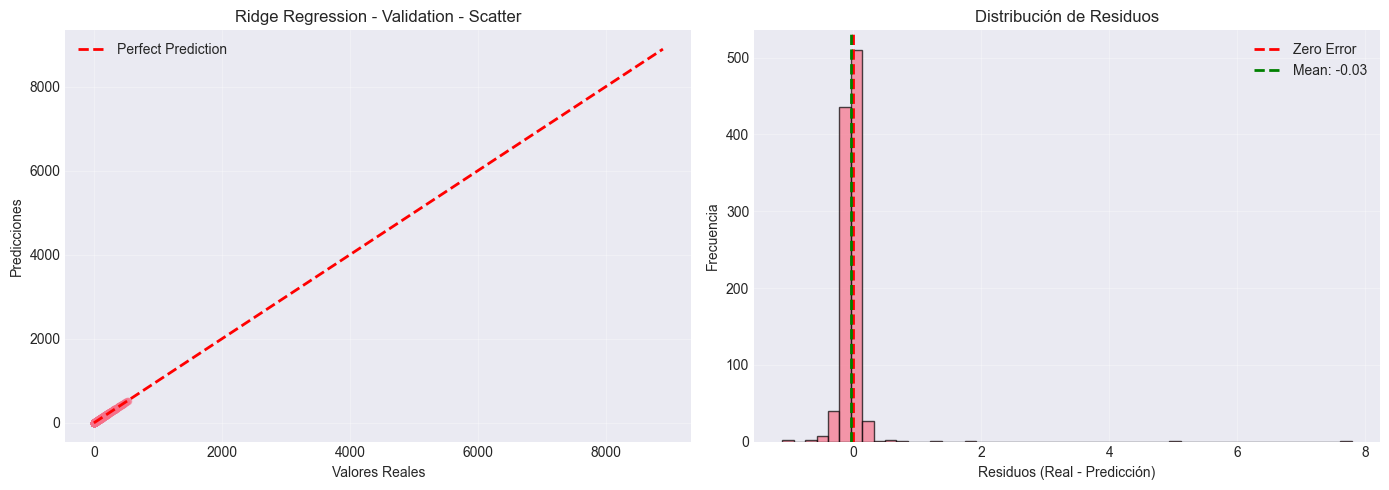

In [8]:
plot_predictions(y_val, y_val_pred_ridge, "Ridge Regression - Validation")


# 6. MODELO 2: RANDOM FOREST

Modelo ensemble basado en árboles de decisión.


## 6.1 Entrenamiento


In [9]:
print("="*70)
print("MODELO 2: RANDOM FOREST")
print("="*70)

# Hiperparámetros
rf_params = {
    'n_estimators': 100,
    'max_depth': 20,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'random_state': 42,
    'n_jobs': -1
}

# MLflow Run
with mlflow.start_run(run_name="random_forest_baseline") as run:
    
    # Log parameters
    mlflow.log_params(rf_params)
    mlflow.log_param("model_type", "Random Forest")
    mlflow.log_param("n_features", len(feature_cols))
    
    # Entrenar modelo
    print("\nEntrenando Random Forest...")
    rf_model = RandomForestRegressor(**rf_params)
    rf_model.fit(X_train, y_train)
    print("✓ Modelo entrenado")
    
    # Predicciones
    y_train_pred_rf = rf_model.predict(X_train)
    y_val_pred_rf = rf_model.predict(X_val)
    y_test_pred_rf = rf_model.predict(X_test)
    
    # Evaluar
    train_metrics_rf = evaluate_model(y_train, y_train_pred_rf, "Train")
    val_metrics_rf = evaluate_model(y_val, y_val_pred_rf, "Validation")
    test_metrics_rf = evaluate_model(y_test, y_test_pred_rf, "Test")
    
    # Log metrics
    for prefix, metrics in [('train', train_metrics_rf), 
                             ('val', val_metrics_rf),
                             ('test', test_metrics_rf)]:
        for metric_name, value in metrics.items():
            mlflow.log_metric(f"{prefix}_{metric_name}", value)
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Log feature importance como artifact
    importance_path = MODELS_DIR / 'rf_feature_importance.csv'
    feature_importance.to_csv(importance_path, index=False)
    mlflow.log_artifact(str(importance_path))
    
    # Log model
    mlflow.sklearn.log_model(rf_model, "model", 
                              registered_model_name="bike-demand-rf")
    
    # Tags
    mlflow.set_tags({
        "model_family": "ensemble",
        "complexity": "medium",
        "base_learner": "decision_tree"
    })
    
    print(f"\n✓ Run ID: {run.info.run_id}")

# Mostrar resultados
print_metrics(train_metrics_rf, "Train")
print_metrics(val_metrics_rf, "Validation")
print_metrics(test_metrics_rf, "Test")


MODELO 2: RANDOM FOREST

Entrenando Random Forest...
✓ Modelo entrenado


2025/10/11 17:53:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/11 17:53:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



✓ Run ID: a2b49325445543a0bd4a0e4119484926

MÉTRICAS - TRAIN
MAE:     13.22  ✓  (target: < 50)
RMSE:   109.94  ✗  (target: < 80)
R²:     0.8559  ✓  (target: > 0.7)
MAPE:    20.06% ✓  (target: < 25%)

Residuos:
  Mean:     0.25  (debe estar ~0)
  Std:    109.94

MÉTRICAS - VALIDATION
MAE:     34.66  ✓  (target: < 50)
RMSE:   200.76  ✗  (target: < 80)
R²:     0.6627  ✗  (target: > 0.7)
MAPE:   133.27% ✗  (target: < 25%)

Residuos:
  Mean:    -5.91  (debe estar ~0)
  Std:    200.67

MÉTRICAS - TEST
MAE:     62.58  ✗  (target: < 50)
RMSE:   183.89  ✗  (target: < 80)
R²:     0.7262  ✓  (target: > 0.7)
MAPE:    51.39% ✗  (target: < 25%)

Residuos:
  Mean:    47.16  (debe estar ~0)
  Std:    177.74


Successfully registered model 'bike-demand-rf'.
Created version '1' of model 'bike-demand-rf'.


## 6.2 Feature Importance


TOP 20 FEATURES MÁS IMPORTANTES - RANDOM FOREST
                feature  importance
          cnt_diff_168h    0.269283
      cnt_pct_change_1h    0.139834
  registered_vs_avg_24h    0.061048
       cnt_acceleration    0.049371
     cnt_pct_change_24h    0.046101
             cnt_lag_1h    0.037916
           casual_share    0.037690
      registered_lag_1h    0.034576
          casual_lag_1h    0.033360
        casual_share_hr    0.028365
      casual_vs_avg_24h    0.019235
                     hr    0.015803
              hr_season    0.013167
      is_commute_window    0.013128
    casual_roll_mean_3h    0.011231
            temp_season    0.011015
       cnt_roll_mean_3h    0.010824
      weathersit_season    0.009623
     cnt_volatility_24h    0.009395
registered_roll_mean_3h    0.009353


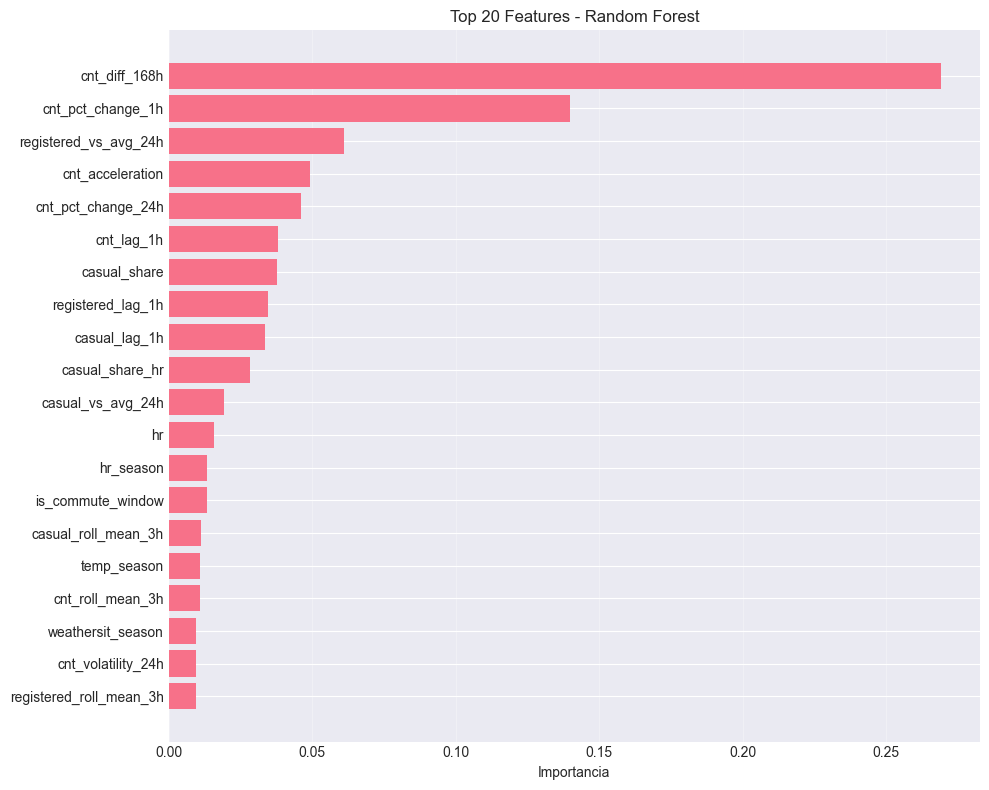

In [10]:
# Mostrar top 20 features
print("="*70)
print("TOP 20 FEATURES MÁS IMPORTANTES - RANDOM FOREST")
print("="*70)
print(feature_importance.head(20).to_string(index=False))

# Visualizar
fig, ax = plt.subplots(figsize=(10, 8))
top_features = feature_importance.head(20)
ax.barh(range(len(top_features)), top_features['importance'])
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.invert_yaxis()
ax.set_xlabel('Importancia')
ax.set_title('Top 20 Features - Random Forest')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


## 6.3 Visualización


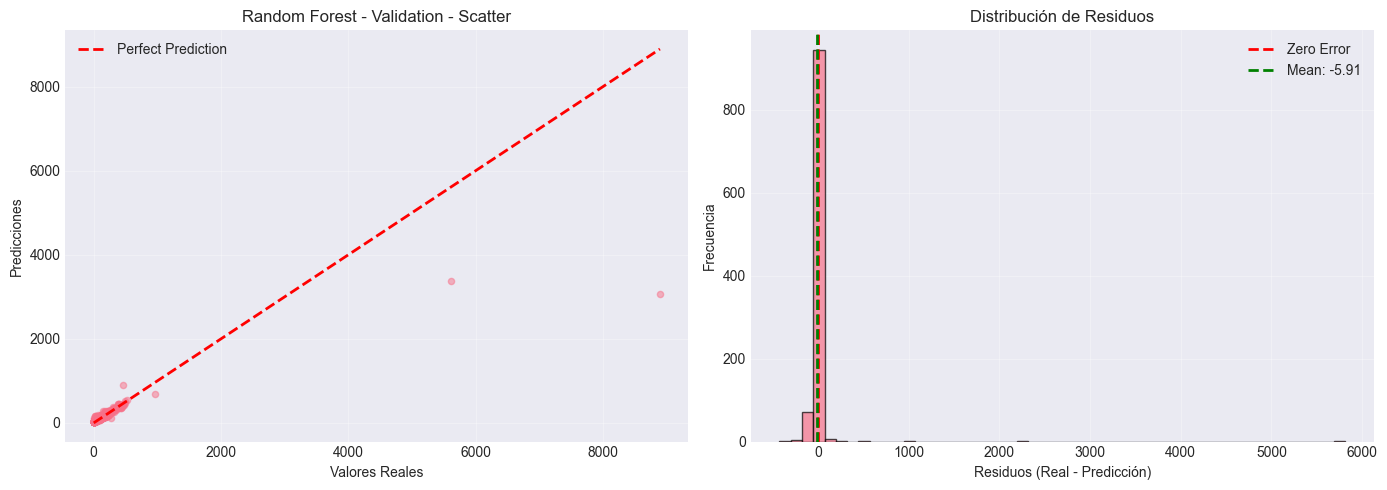

In [11]:
plot_predictions(y_val, y_val_pred_rf, "Random Forest - Validation")


# 7. MODELO 3: XGBOOST

Modelo de gradient boosting (modelo principal según ML Canvas).


## 7.1 Entrenamiento


In [12]:
print("="*70)
print("MODELO 3: XGBOOST")
print("="*70)

# Hiperparámetros
xgb_params = {
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'gamma': 0,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'random_state': 42,
    'n_jobs': -1
}

# MLflow Run
with mlflow.start_run(run_name="xgboost_baseline") as run:
    
    # Log parameters
    mlflow.log_params(xgb_params)
    mlflow.log_param("model_type", "XGBoost")
    mlflow.log_param("n_features", len(feature_cols))
    
    # Entrenar modelo
    print("\nEntrenando XGBoost...")
    xgb_model = XGBRegressor(**xgb_params)
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=False
    )
    print("✓ Modelo entrenado")
    
    # Predicciones
    y_train_pred_xgb = xgb_model.predict(X_train)
    y_val_pred_xgb = xgb_model.predict(X_val)
    y_test_pred_xgb = xgb_model.predict(X_test)
    
    # Evaluar
    train_metrics_xgb = evaluate_model(y_train, y_train_pred_xgb, "Train")
    val_metrics_xgb = evaluate_model(y_val, y_val_pred_xgb, "Validation")
    test_metrics_xgb = evaluate_model(y_test, y_test_pred_xgb, "Test")
    
    # Log metrics
    for prefix, metrics in [('train', train_metrics_xgb), 
                             ('val', val_metrics_xgb),
                             ('test', test_metrics_xgb)]:
        for metric_name, value in metrics.items():
            mlflow.log_metric(f"{prefix}_{metric_name}", value)
    
    # Feature importance
    feature_importance_xgb = pd.DataFrame({
        'feature': feature_cols,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Log feature importance
    importance_path_xgb = MODELS_DIR / 'xgb_feature_importance.csv'
    feature_importance_xgb.to_csv(importance_path_xgb, index=False)
    mlflow.log_artifact(str(importance_path_xgb))
    
    # Log model
    mlflow.xgboost.log_model(xgb_model, "model", 
                              registered_model_name="bike-demand-xgboost")
    
    # Tags
    mlflow.set_tags({
        "model_family": "boosting",
        "complexity": "medium",
        "algorithm": "gradient_boosting"
    })
    
    print(f"\n✓ Run ID: {run.info.run_id}")

# Mostrar resultados
print_metrics(train_metrics_xgb, "Train")
print_metrics(val_metrics_xgb, "Validation")
print_metrics(test_metrics_xgb, "Test")


MODELO 3: XGBOOST

Entrenando XGBoost...
✓ Modelo entrenado


2025/10/11 17:53:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/11 17:53:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



✓ Run ID: c73316be3a8949b99d4773a921b0cf7e

MÉTRICAS - TRAIN
MAE:      6.91  ✓  (target: < 50)
RMSE:    10.68  ✓  (target: < 80)
R²:     0.9986  ✓  (target: > 0.7)
MAPE:    17.83% ✓  (target: < 25%)

Residuos:
  Mean:     0.03  (debe estar ~0)
  Std:     10.68

MÉTRICAS - VALIDATION
MAE:     19.54  ✓  (target: < 50)
RMSE:   169.62  ✗  (target: < 80)
R²:     0.7592  ✓  (target: > 0.7)
MAPE:    27.97% ✗  (target: < 25%)

Residuos:
  Mean:     4.39  (debe estar ~0)
  Std:    169.56

MÉTRICAS - TEST
MAE:     56.15  ✗  (target: < 50)
RMSE:   226.70  ✗  (target: < 80)
R²:     0.5839  ✗  (target: > 0.7)
MAPE:    26.91% ✗  (target: < 25%)

Residuos:
  Mean:     9.35  (debe estar ~0)
  Std:    226.51


Successfully registered model 'bike-demand-xgboost'.
Created version '1' of model 'bike-demand-xgboost'.


## 7.2 Feature Importance


TOP 20 FEATURES MÁS IMPORTANTES - XGBOOST
                   feature  importance
weather_quadrant_frio_seco    0.246446
         weathersit_season    0.178499
        weekday_weathersit    0.088175
             cnt_diff_168h    0.079576
                        hr    0.051603
           thermal_comfort    0.030735
        cnt_pct_change_24h    0.030562
                    hr_cos    0.026594
     registered_vs_avg_24h    0.021792
           casual_lag_168h    0.017406
              is_peak_hour    0.016617
                cnt_lag_1h    0.013839
         cnt_roll_mean_24h    0.012900
                    hr_sin    0.011880
       registered_lag_168h    0.011395
                       hum    0.010605
                   weekday    0.010075
          cnt_roll_mean_3h    0.009528
          cnt_acceleration    0.008674
         cnt_pct_change_1h    0.008494


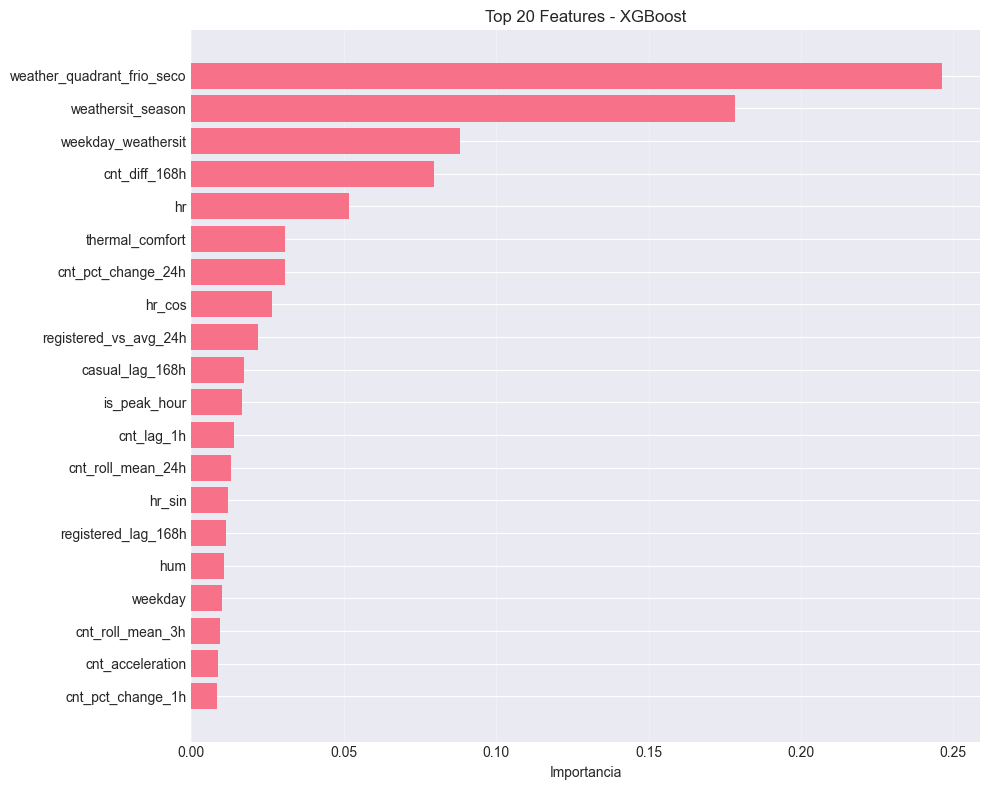

In [13]:
# Mostrar top 20 features
print("="*70)
print("TOP 20 FEATURES MÁS IMPORTANTES - XGBOOST")
print("="*70)
print(feature_importance_xgb.head(20).to_string(index=False))

# Visualizar
fig, ax = plt.subplots(figsize=(10, 8))
top_features_xgb = feature_importance_xgb.head(20)
ax.barh(range(len(top_features_xgb)), top_features_xgb['importance'])
ax.set_yticks(range(len(top_features_xgb)))
ax.set_yticklabels(top_features_xgb['feature'])
ax.invert_yaxis()
ax.set_xlabel('Importancia')
ax.set_title('Top 20 Features - XGBoost')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


## 7.3 Visualización


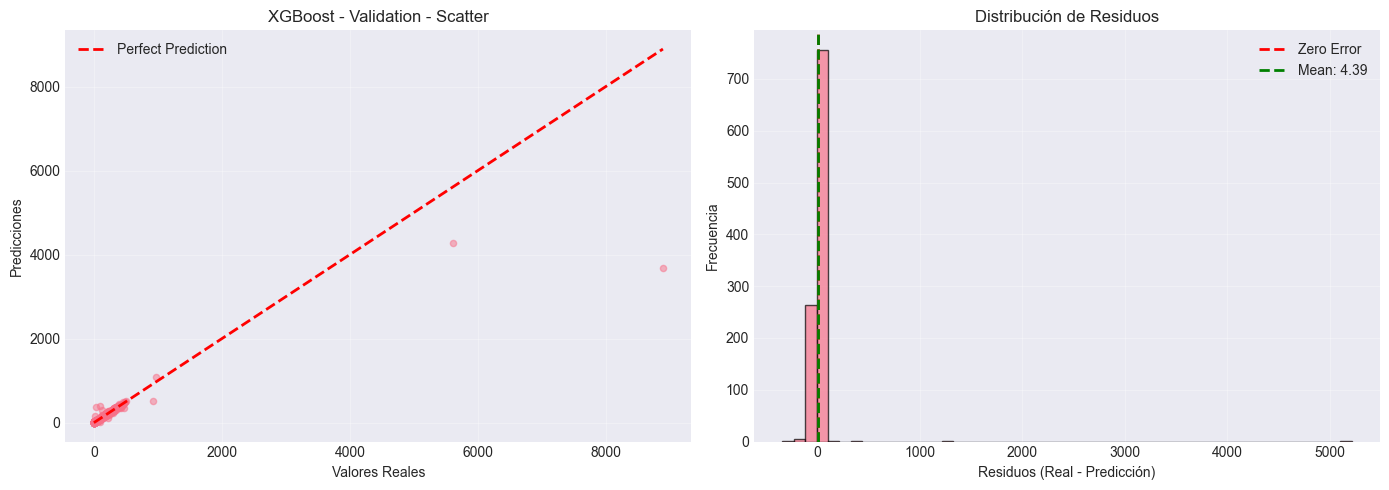

In [14]:
plot_predictions(y_val, y_val_pred_xgb, "XGBoost - Validation")


# 8. COMPARACIÓN DE MODELOS

Comparamos los 3 modelos baseline para seleccionar el mejor.


In [15]:
# Crear tabla comparativa
comparison_df = pd.DataFrame([
    {
        'Model': 'Ridge Regression',
        'Train_MAE': train_metrics_ridge['mae'],
        'Val_MAE': val_metrics_ridge['mae'],
        'Test_MAE': test_metrics_ridge['mae'],
        'Train_RMSE': train_metrics_ridge['rmse'],
        'Val_RMSE': val_metrics_ridge['rmse'],
        'Test_RMSE': test_metrics_ridge['rmse'],
        'Train_R2': train_metrics_ridge['r2'],
        'Val_R2': val_metrics_ridge['r2'],
        'Test_R2': test_metrics_ridge['r2'],
        'Val_MAPE': val_metrics_ridge['mape']
    },
    {
        'Model': 'Random Forest',
        'Train_MAE': train_metrics_rf['mae'],
        'Val_MAE': val_metrics_rf['mae'],
        'Test_MAE': test_metrics_rf['mae'],
        'Train_RMSE': train_metrics_rf['rmse'],
        'Val_RMSE': val_metrics_rf['rmse'],
        'Test_RMSE': test_metrics_rf['rmse'],
        'Train_R2': train_metrics_rf['r2'],
        'Val_R2': val_metrics_rf['r2'],
        'Test_R2': test_metrics_rf['r2'],
        'Val_MAPE': val_metrics_rf['mape']
    },
    {
        'Model': 'XGBoost',
        'Train_MAE': train_metrics_xgb['mae'],
        'Val_MAE': val_metrics_xgb['mae'],
        'Test_MAE': test_metrics_xgb['mae'],
        'Train_RMSE': train_metrics_xgb['rmse'],
        'Val_RMSE': val_metrics_xgb['rmse'],
        'Test_RMSE': test_metrics_xgb['rmse'],
        'Train_R2': train_metrics_xgb['r2'],
        'Val_R2': val_metrics_xgb['r2'],
        'Test_R2': test_metrics_xgb['r2'],
        'Val_MAPE': val_metrics_xgb['mape']
    }
])

print("="*100)
print("COMPARACIÓN DE MODELOS BASELINE")
print("="*100)
print(comparison_df.to_string(index=False))

# Identificar mejor modelo por validation
best_idx = comparison_df['Val_RMSE'].idxmin()
best_model = comparison_df.iloc[best_idx]['Model']

print(f"\n{'='*100}")
print(f"🏆 MEJOR MODELO: {best_model}")
print(f"{'='*100}")
print(f"  Validation MAE:  {comparison_df.iloc[best_idx]['Val_MAE']:.2f}  (target: < {TARGET_METRICS['MAE']})")
print(f"  Validation RMSE: {comparison_df.iloc[best_idx]['Val_RMSE']:.2f}  (target: < {TARGET_METRICS['RMSE']})")
print(f"  Validation R²:   {comparison_df.iloc[best_idx]['Val_R2']:.4f}  (target: > {TARGET_METRICS['R2']})")
print(f"  Validation MAPE: {comparison_df.iloc[best_idx]['Val_MAPE']:.2f}%  (target: < {TARGET_METRICS['MAPE']}%)")

# Guardar comparación
comparison_path = MODELS_DIR / 'model_comparison.csv'
comparison_df.to_csv(comparison_path, index=False)
print(f"\n✓ Comparación guardada en: {comparison_path}")


COMPARACIÓN DE MODELOS BASELINE
           Model  Train_MAE   Val_MAE  Test_MAE  Train_RMSE   Val_RMSE  Test_RMSE  Train_R2   Val_R2  Test_R2   Val_MAPE
Ridge Regression   0.073267  0.098044  0.115951    0.240699   0.324154   0.298394  0.999999 0.999999 0.999999   0.287193
   Random Forest  13.219688 34.663965 62.579726  109.942396 200.756960 183.892046  0.855938 0.662685 0.726203 133.273925
         XGBoost   6.908412 19.536916 56.149515   10.682509 169.618185 226.699841  0.998640 0.759210 0.583893  27.972080

🏆 MEJOR MODELO: Ridge Regression
  Validation MAE:  0.10  (target: < 50)
  Validation RMSE: 0.32  (target: < 80)
  Validation R²:   1.0000  (target: > 0.7)
  Validation MAPE: 0.29%  (target: < 25%)

✓ Comparación guardada en: c:\Users\gairo\OneDrive\Documents\Tec_De_Monterrey\MLOps\Proyecto\mlops-team-61-project\models\model_comparison.csv


# 9. RESUMEN Y PRÓXIMOS PASOS

---

## ✅ Modelos Entrenados

1. **Ridge Regression** - Baseline lineal simple
2. **Random Forest** - Ensemble de árboles
3. **XGBoost** - Gradient boosting (modelo principal)

## 📊 Métricas Objetivo

| Métrica | Target | Descripción |
|---------|--------|-------------|
| MAE | < 50 | Error absoluto medio |
| RMSE | < 80 | Error cuadrático medio |
| R² | > 0.7 | Coeficiente de determinación |
| MAPE | < 25% | Error porcentual medio |

## 🚀 Próximos Pasos

1. **Análisis de errores por segmentos** (hora, clima, season)
2. **Hyperparameter tuning** del mejor modelo
3. **Feature selection** basado en importance
4. **Ensemble de modelos** (stacking/blending)
5. **Evaluación exhaustiva** con test set
6. **Deployment** del modelo final

## 📝 Archivos Generados

- `models/rf_feature_importance.csv`
- `models/xgb_feature_importance.csv`
- `models/model_comparison.csv`
- MLflow runs en `mlruns/`

## 🔗 MLflow UI

Para visualizar experimentos:
```bash
mlflow ui
```

Abrir: http://localhost:5000

---

**Notebook completado:** `02_modeling.ipynb`  
**Estado:** ✅ Modelos baseline entrenados  
**Siguiente:** Optimización y evaluación exhaustiva
